<h1><center> ML DSL in Action </center></h1>

Amazon AWS: 
1. Amazon EMR
2. Amazon S3
3. Amazon SageMaker

In [2]:
import logging
import boto3
from botocore.exceptions import ClientError
import os
import numpy as np

import com.griddynamics.dsl.ml.mldsl as mldsl
from com.griddynamics.dsl.ml.mldsl import job_tracker
from com.griddynamics.dsl.ml.settings.profiles import SageMakerProfile, PySparkJobProfile
from com.griddynamics.dsl.ml.settings.description import Platform

## Prepare Sequences from Original Text

### Tokenizer to Create Sequences 

### Execute Tokenizer on ML Platform

In [16]:
%%py_script --name text_tokenizer.py --path demo/scripts
# %py_load demo/scripts/text_tokenizer.py
#!/usr/bin/python
from pyspark import SQLContext, SparkContext
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql.types import ArrayType, IntegerType, FloatType
from pyspark.ml.feature import Tokenizer
import argparse


def read_glove_vecs(glove_file, output_path):
    rdd = sc.textFile(glove_file)
    row = Row("glovevec")
    df = rdd.map(row).toDF()
    split_col = F.split(F.col('glovevec'), " ")
    df = df.withColumn('word', split_col.getItem(0))
    df = df.withColumn('splitted', split_col)
    vec_udf = F.udf(lambda row: [float(i) for i in row[1:]], ArrayType(FloatType()))
    df = df.withColumn('vec', vec_udf(F.col('splitted')))
    df = df.drop('splitted', "glovevec")
    w = Window.orderBy(["word"])
    qdf = df.withColumn('vec', F.concat_ws(',', 'vec')).withColumn("id", F.row_number().over(w))
    
    path = '{}/words'.format(output_path)
    qdf.coalesce(1).write.format('csv').option("sep","\t").option('header', 'true').save(path)
    print('Words saved to: "{}"'.format(path))
    list_words = list(map(lambda row: row.asDict(), qdf.collect()))
    word_to_vec_map = {item['word']: item['vec'] for item in list_words}
    words_to_index = {item['word']:item["id"] for item in list_words}
    index_to_words = {item["id"]: item['word'] for item in list_words}
    return words_to_index, index_to_words, word_to_vec_map


def prepare_df(path, const, words_to_index):
    rdd = sc.textFile(path)
    row = Row("review")
    df = rdd.map(row).toDF()
    # Clean text
    df_clean = df.select(F.lower(F.regexp_replace(F.col('review'), "n't", " n't")).alias('review'))
    df_clean = df_clean.select(F.lower(F.regexp_replace(F.col('review'), "[^0-9a-zA-Z\\s]", "")).alias('review'))
    # Tokenize text
    tokenizer = Tokenizer(inputCol='review', outputCol='words_token')
    df_words_token = tokenizer.transform(df_clean).select('words_token')
    df_cutted = df_words_token.withColumn('length', F.size(F.col('words_token')))
    # Replace word with it's index
    word_udf = F.udf(lambda row: [words_to_index[w] if w in words_to_index.keys()
                                  else words_to_index["unk"] for w in row],
                 ArrayType(IntegerType()))
    df_stemmed = df_cutted.withColumn('words_stemmed', word_udf(F.col('words_token')))
    return df_stemmed.withColumn("class", F.lit(const))


def save_dataset(df_pos, df_neg, path):
    df = df_pos.union(df_neg)
    w = Window.orderBy(["words_stemmed"])
    df = df.withColumn("review_id", F.row_number().over(w)).withColumn('int_seq',
                                                                       F.concat_ws(',', 'words_stemmed'))
    qdf = df.select(['review_id', 'int_seq', 'class'])
    qdf.coalesce(1).write.format('csv').option('header', 'true').save(path)

    
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train_path', type=str, help="train positive reviews path")
    parser.add_argument('--test_path', type=str, help="test positive reviews path")
    parser.add_argument('--word_embeds', type=str, help="Path to glove word embeddings")
    parser.add_argument('--output_path', type=str, help="Sequences output path")
    reviews_filter = '*.txt'

    args, d = parser.parse_known_args()
    output_path = args.output_path
    SparkContext.setSystemProperty('spark.sql.broadcastTimeout', '36000')
    sc = SparkContext(appName="word_tokenizer").getOrCreate()
    sql = SQLContext(sc)

    words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(args.word_embeds, output_path)
    
    df_pos = prepare_df(f"{args.train_path}/pos/{reviews_filter}", 1, words_to_index)
    df_neg = prepare_df(f"{args.train_path}/neg/{reviews_filter}", 0, words_to_index)
    train_path = '{}/train'.format(output_path)
    save_dataset(df_pos, df_neg, train_path)
    print('Train saved to: "{}"'.format(train_path))

    df_pos = prepare_df(f"{args.test_path}/pos/{reviews_filter}", 1, words_to_index)
    df_neg = prepare_df(f"{args.test_path}/neg/{reviews_filter}", 0, words_to_index)
    test_path = '{}/test'.format(output_path)
    save_dataset(df_pos, df_neg, test_path)
    print('Test saved to: "{}"'.format(test_path))

Temporary path: /Users/apolatovskaya/git/ml-dsl/.mldsl/text_tokenizer.py


In [17]:
platform = Platform.AWS
profile = PySparkJobProfile(bucket='mldsl-test', 
                            cluster='j-IUSED1D1H8F6',
                            region='global',
                            job_prefix='movie_review_job',
                            root_path='demo/scripts', project=None, ai_region='us-east-1', 
                            job_async=False,
                            use_cloud_engine_credentials='SageMakerRoleMlDsl')
profile.args=profile.load_profile_data("demo/spark_job_args_aws.json")
profile.packages=["com.amazonaws:aws-java-sdk-pom:1.10.34", "org.apache.hadoop:hadoop-aws:2.6.0"]
PySparkJobProfile.set('JobProfile', profile)

In [18]:
%py_data -n text_tokenizer.py -p JobProfile -pm $platform -o s3://mldsl-test/movie

Parameters string = <<<-n text_tokenizer.py -p JobProfile -pm 2 -o s3://mldsl-test/movie>>>
mldsl-test
Uploaded text_tokenizer.py to s3://mldsl-test/emr/j-IUSED1D1H8F6/movie_review_job_1593105239/text_tokenizer.py
Submitting movie_review_job_1593105239 to cluster j-IUSED1D1H8F6
Step movie_review_job_1593105239 change state to PENDING
Step movie_review_job_1593105239 change state to RUNNING
Throttling Exception Occured.
Retrying.....
Throttling Exception Occured.
Retrying.....
Throttling Exception Occured.
Retrying.....
Throttling Exception Occured.
Retrying.....
Throttling Exception Occured.
Retrying.....
Throttling Exception Occured.
Retrying.....
Throttling Exception Occured.
Retrying.....
Throttling Exception Occured.
Retrying.....
Step movie_review_job_1593105239 change state to COMPLETED


<IPython.core.display.JSON object>

In [ ]:
#Use job_movie_review_job_1593105239 instance to browse job properties.
#job_movie_review_job_1593105239 = job_tracker['movie_review_job_1593105239']

# ML Model to Predict Positive or Negative Review

In [20]:
#Set some env variables to run script locally
os.environ['SM_MODEL_DIR'] = 'notebooks/demo/model/'
os.environ['SM_CHANNEL_TRAINING'] = 'notebooks/demo/data/'

#### LSTM Train Script

In [25]:
%%py_script -e --name pytorch_model.py --path notebooks/demo/scripts --epochs 3
# %py_load scripts/pytorch_model.py
#!/usr/bin/python
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import itertools
import os
import argparse
import json
from shutil import copy2
import boto3
import io
import pandas as pd

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index)
    emb_dim = word_to_vec_map.item().get("apple").shape[0]
    emb_matrix = np.zeros((vocab_len, emb_dim))
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = np.float32(word_to_vec_map.item().get(word))
    return emb_matrix

def accuracy(a, b):
    a = torch.argmax(a, dim=1)
    b = torch.argmax(b, dim=1)
    return torch.sum(torch.eq(a, b)).float() / list(a.size())[0]

def convert_to_one_hot(Y, C=2):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def prepare_dataset(data, N, word_to_index):
    data['int_seq'] = data['int_seq'].apply(lambda x: [float(i) for i in x.split(',')])
    print("Max sequence is set to {}".format(N))
    data['int_seq'] = data['int_seq'].apply(lambda x: (x + [word_to_index["unk"]] * N)[:N])
    ds_x = np.asarray(list(data["int_seq"]))
    ds_y = data["class"].values
    ds_y = convert_to_one_hot(ds_y)
    return ds_x, ds_y

class LSTMModel(nn.Module):
    # predict steps is output_dim lstm_size is hidden dim of LSTM cell
    def __init__(self, word_to_vec_map, word_to_index, lstm_size=32, input_len=200):
        super(LSTMModel, self).__init__()
        torch.manual_seed(1)
        self.lstm_size = lstm_size
        self.input_len = input_len
        emb_matrix = pretrained_embedding_layer(word_to_vec_map, word_to_index)
        self.vocab_len = len(word_to_index)
        self.emb_dim = word_to_vec_map.item().get("apple").shape[0]

        self.embedding = nn.Embedding(self.vocab_len, self.emb_dim)
        self.embedding.weight = nn.Parameter(torch.from_numpy(emb_matrix))
        self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(self.emb_dim, self.lstm_size, 2, dropout=0.5, batch_first=True)
        self.out = nn.Linear(self.lstm_size, 2)

    def forward(self, data):
        x = self.embedding(data.long())
        x, _ = self.lstm(x.view(len(data), -1, self.emb_dim))
        x = x[:, -1, :]
        x = self.out(x)
        x = F.softmax(x)
        return x

def model_fn(model_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bucket = 'mldsl-test'
    s3 = boto3.resource('s3')
    
    content_object = s3.Object(bucket, 'movie/word_to_index.json')
    file_content = content_object.get()['Body'].read().decode('utf-8')
    word_to_index = json.loads(file_content)
    
    obj = s3.Object(bucket, 'movie/word_to_vec_map.npy')
    with io.BytesIO(obj.get()["Body"].read()) as f:
        word_to_vec_map = np.load(f, allow_pickle=True)
    
    model = LSTMModel(word_to_vec_map, word_to_index)
    with open(os.path.join(model_dir, 'movie.pth'), 'rb') as f:
        model.load_state_dict(torch.load(f))
    model = model.float()
    return model.to(device)


if __name__ =='__main__':
    parser = argparse.ArgumentParser()
    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=20)
    parser.add_argument('--batch_size', type=int, default=1024)
    parser.add_argument('--learning_rate', type=float, default=0.03)
    # Data, model, and output directories
    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    args, _ = parser.parse_known_args()

    np.random.seed(1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with open(os.path.join(args.train, "word_to_index.json"), 'r') as f:
        word_to_index = json.load(f)
    word_to_vec_map = np.load(os.path.join(args.train, "word_to_vec_map.npy"), allow_pickle=True)

    model = LSTMModel(word_to_vec_map, word_to_index, lstm_size=32, input_len=150)
    model = model.float()
    parameters = itertools.filterfalse(lambda p: not p.requires_grad, model.parameters())
    # Optimizer
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(parameters, lr=args.learning_rate)
    model.to(device)
    
    train_path = os.path.join(args.train, 'train/')
    for file in os.listdir(train_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(train_path, file))

    x_train, y_train = prepare_dataset(df, 150, word_to_index)
    
    tensor_x = torch.tensor(x_train).float()
    tensor_y = torch.tensor(y_train).float()
    
    print("Positive examples are {}".format(sum(tensor_y[:, 0])))
    print("Negative examples are {}".format(sum(tensor_y[:, 1])))
    del x_train
    del y_train

    traindataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)
    trainloader = torch.utils.data.DataLoader(traindataset, shuffle=True, batch_size=args.batch_size)

    epochs = args.epochs
    running_loss = 0
    train_losses = []

    for epoch in range(epochs):
        start = time.time()
        for inputs, label in trainloader:
            inputs, label = inputs.to(device), label.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, label)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_losses.append(running_loss / len(trainloader))
            model.train()
        print(f"""Epoch {epoch+1}/{epochs}..  Train loss: {np.mean(train_losses):.3f}..  Accuracy: {accuracy(label, logps):.3f}..  Time: {(time.time() - start):.2f}""")
        running_loss = 0
    copy2(os.path.join(args.train, "word_to_index.json"), os.path.join(args.model_dir, "word_to_index.json"))
    copy2(os.path.join(args.train, "word_to_vec_map.npy"), os.path.join(args.model_dir, "word_to_vec_map.npy"))
    
    with open(os.path.join(args.model_dir, 'movie.pth'), 'wb') as f:
        torch.save(model.state_dict(), f)


Max sequence is set to 150
Positive examples are 111.0
Negative examples are 111.0


/Users/apolatovskaya/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/3..  Train loss: 0.693..  Accuracy: 0.536..  Time: 0.46
Epoch 2/3..  Train loss: 0.711..  Accuracy: 0.500..  Time: 0.92
Epoch 3/3..  Train loss: 0.704..  Accuracy: 0.532..  Time: 0.91
[Errno 2] No such file or directory: 'notebooks/demo/model/word_to_index.json'
Temporary path: /Users/apolatovskaya/git/ml-dsl/.mldsl/pytorch_model.py


In [26]:
from sagemaker.pytorch import PyTorch

platform = Platform.AWS
profile = SageMakerProfile(bucket='mldsl-test', cluster='ai4ops', region='us-east-1', job_prefix='mldsl_test',
                           container=PyTorch, root_path='notebooks/demo/scripts/', 
                           framework_version='1.4.0', instance_type='ml.m4.xlarge',
                          use_cloud_engine_credentials='SageMakerRoleMlDsl')

SageMakerProfile.set('SageMakerProfile', profile)

In [27]:
%py_train -n pytorch_model.py -p SageMakerProfile -pm $platform -o s3://mldsl-test/movie/ --training s3://mldsl-test/movie/movie_review_job_1591218321

2020-06-25 18:22:39 Starting - Starting the training job...
2020-06-25 18:22:42 Starting - Launching requested ML instances.........
2020-06-25 18:24:28 Starting - Preparing the instances for training......
2020-06-25 18:25:32 Downloading - Downloading input data...
2020-06-25 18:26:02 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-06-25 18:26:32,917 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-06-25 18:26:32,922 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-06-25 18:26:32,933 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-06-25 18:26:35,962 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-06-25 18:26:36,365 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.p

<IPython.core.display.JSON object>

In [30]:
#Use job_mldsl_test_1593109354 instance to browse job properties.
#
job_mldsl_test_1593109354 = job_tracker['mldsl_test_1593109354']

### Deployment of model

In [31]:
predictor = job_mldsl_test_1593109354.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge',
                                             endpoint_name='mldsl-pytorch')

---------------!

In [34]:
def convert_to_one_hot(Y, C=2):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def prepare_dataset(data, N, word_to_index):
    data['int_seq'] = data['int_seq'].apply(lambda x: [float(i) for i in x.split(',')])
    print("Max sequence is set to {}".format(N))
    data['int_seq'] = data['int_seq'].apply(lambda x: (x + [word_to_index["unk"]] * N)[:N])
    ints = np.random.choice(len(data), 500)
    ds_x = np.asarray(list(data.loc[ints, "int_seq"]))
    ds_y = data.loc[ints, "class"].values
    ds_y = convert_to_one_hot(ds_y)
    return ds_x, ds_y

data_key = "movie/movie_review_job_1591218321/test"
bucket='mldsl-test'
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucket)
for obj in my_bucket.objects.filter(Prefix=data_key):
    if obj.key.endswith("csv"):
        data_location = 's3://{}/{}'.format(obj.bucket_name, obj.key)
        df = pd.read_csv(data_location)
x_test, y_test = prepare_dataset(df, 150, word_to_index)
y = y_test.argmax(axis=1)
target_names = ['negative review', 'positive review']

Max sequence is set to 150


In [35]:
preds = predictor.predict(x_test)
prediction = preds.argmax(axis=1)

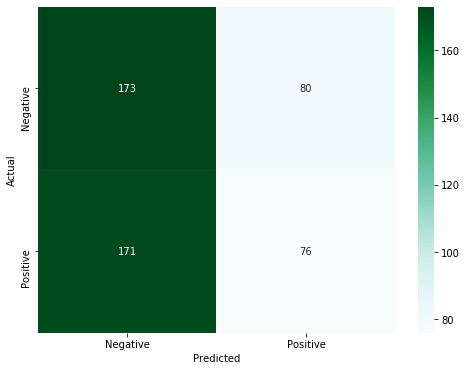

In [36]:
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_mat = confusion_matrix(y, prediction)
fig, ax = plt.subplots(figsize=(8,6))
classes=['Negative', 'Positive']
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=classes, yticklabels=classes, cmap=plt.cm.BuGn)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Deployment of model trained outside

In [37]:
from sagemaker.pytorch import PyTorchModel
profile.model_data = 's3://sagemaker-us-east-1-592068120969/pytorch-training-2020-06-04-10-19-13-527/model.tar.gz'
profile.container = PyTorchModel
SageMakerProfile.set('TestDeploySMProfile', profile)

In [38]:
%py_deploy -n pytorch_model.py -p TestDeploySMProfile -pm $platform

---------------!

<IPython.core.display.JSON object>

In [39]:
#Use job_mldsl_test_1593153514 instance to browse job properties.
predictor=job_tracker['mldsl_test_1593153514']

## PREDICTION

In [40]:
preds = predictor.predict(x_test)
prediction = preds.argmax(axis=1)
target_names = ['negative review', 'positive review']

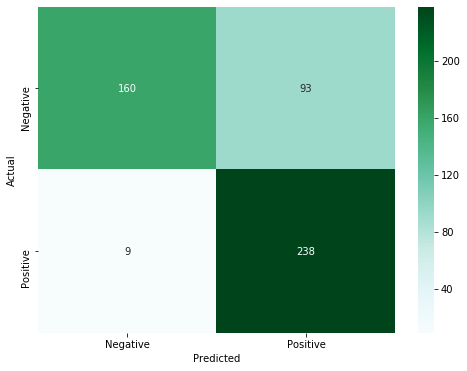

In [41]:
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_mat = confusion_matrix(y, prediction)
fig, ax = plt.subplots(figsize=(8,6))
classes=['Negative', 'Positive']
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=classes, yticklabels=classes, cmap=plt.cm.BuGn)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [42]:
print(classification_report(y, prediction,target_names=target_names))

                 precision    recall  f1-score   support

negative review       0.95      0.63      0.76       253
positive review       0.72      0.96      0.82       247

       accuracy                           0.80       500
      macro avg       0.83      0.80      0.79       500
   weighted avg       0.83      0.80      0.79       500

